<a href="https://colab.research.google.com/github/jungry/time_series/blob/main/TimeSeries_Practice10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Handling Missing Values and Outliers in Time Series Data

## Outlier Detection
이상치는 다른 관측값들과 크게 벗어난 데이터 포인트를 의미.

ML 모델링에서는 이상치가 데이터 분포에서 다른 값들과 크게 차이가 나는 비정상적인 값으로, 모델의 성능을 저하시킬 수 있기 때문에 주의가 필요한 데이터 포인트이다.

### 1. Distribution-Based Methods

#### 1.1. Chauvenet's Criterion
쇼베네의 기준(Chauvenet’s Criterion)은 발생 확률을 기반으로 이상치를 식별하는 통계적 방법이다.

In [6]:
# Google Mount
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt

In [8]:
hb_data = pd.read_csv('/content/drive/Shared drives/timeseries-datasets/heartbeat_sensordata.csv')
hb_data.info()
hb_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   datetime        100 non-null    object
 1   heartbeat_rate  100 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 1.7+ KB


,datetime,heartbeat_rate
0,2024-01-03 00:00:00,79
1,2024-01-03 01:00:00,72
2,2024-01-03 02:00:00,75
3,2024-01-03 03:00:00,81
4,2024-01-03 04:00:00,79


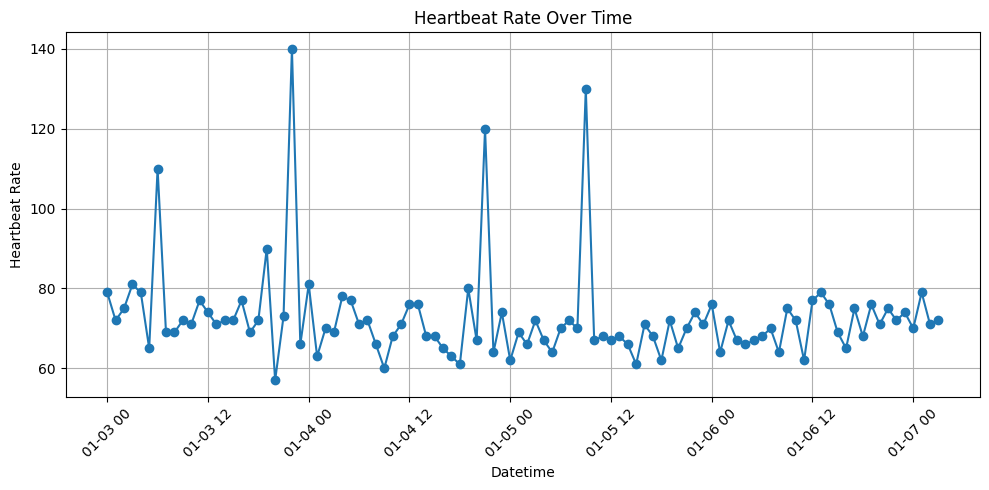

In [9]:
# ‘datetime’ 열을 datetime 객체로 변환하는 것이 좋은 관례
# 1. 데이터 및 시간 연산: datetime으로 변환하면 날짜 차이를 계산하거나 특정 날짜로 데이터를 필터링하는 등의 작업을 쉽게 할 수 있음.
# 2. 정확한 정렬: datetime 형식으로 변환하면 데이터를 시간 순으로 정확하게 정렬할 수 있음.

hb_data['datetime'] = pd.to_datetime(hb_data['datetime'])

plt.figure(figsize=(10, 5))
plt.plot(hb_data['datetime'], hb_data['heartbeat_rate'], marker='o', linestyle='-')
plt.title('Heartbeat Rate Over Time')
plt.xlabel('Datetime')
plt.ylabel('Heartbeat Rate')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [10]:
def chauvenet_criterion(data): # data: 이상치를 찾을 데이터. 배열형태
    mean = np.mean(data) # 평균을 구함
    std_dev = np.std(data) # 표준편차를 구함
    N = len(data) # 데이터의 개수를 구함

    # Z-점수 계산: 각 데이터가 평균으로부터 몇 표준편차만큼 떨어져 있는지 나타내는 값
    z_scores = np.abs(data - mean) / std_dev

    # Z-점수에 해당하는 확률 계산: 확률 분포에 따라 Z-점수보다 더 극단적인 값이 나올 확률(Z-점수가 주어진 값보다 더 큰(혹은 작은) 값을 가지는 데이터가 나올 확률)
    probabilities = 1 - stats.norm.cdf(z_scores)

    # Chauvenet's Criterion 임계값 계산: 이 임계값보다 작은 확률을 가진 값은 이상치로 간주
    criterion_threshold = 1.0 / (2 * N)

    # 이상치 탐지: 확률이 임계값보다 작은 값들이 이상치로 간주
    outliers = data[probabilities < criterion_threshold]
    return outliers

	•	평균(mean): 데이터의 중심을 나타내는 값. 전체 데이터의 합을 데이터의 개수로 나눈 값.
	•	표준편차(std_dev): 데이터가 평균으로부터 얼마나 퍼져 있는지를 나타내는 값. 퍼짐 정도를 측정.
	•	Z-점수: 각 데이터 포인트가 평균으로부터 몇 표준편차만큼 떨어져 있는지를 나타내는 값. Z = (X - 평균) / 표준편차
	•	누적분포함수(CDF, Cumulative Distribution Function): Z-점수에 해당하는 확률을 계산하는 함수. 이 값은 주어진 값보다 작은 확률을 나타냄.
	•	Chauvenet’s Criterion: 데이터에서 이상치를 판별하는 방법. 1 / (2 * N)을 기준으로 이보다 작은 확률을 가진 값을 이상치로 판단.

이 코드는 주어진 데이터에서 Z-점수와 그에 해당하는 확률을 이용해 이상치를 찾아내는 방식이다. Chauvenet’s Criterion을 사용하여, 확률이 지정된 기준값보다 작은 데이터 포인트를 이상치로 간주하게 된다.

In [11]:
# 'heartbeat_rate' 열을 추출하여 변수에 저장
heartbeat_data = hb_data['heartbeat_rate']

# Chauvenet's Criterion을 사용하여 이상치 탐지
outliers = chauvenet_criterion(heartbeat_data)

# 이상치 출력
print("Outliers identified by Chauvenet's Criterion:", outliers)

# 이상치에 해당하는 인덱스를 찾아 True/False 값으로 반환
outlier_indices = hb_data['heartbeat_rate'].isin(outliers)

Outliers identified by Chauvenet's Criterion: 6     110
22    140
45    120
57    130
Name: heartbeat_rate, dtype: int64


	•	heartbeat_data: 심박수 데이터.
	•	chauvenet_criterion: Chauvenet의 기준을 사용하여 이상치를 탐지하는 함수.
	•	isin(): 주어진 값이 시리즈에 포함되는지 여부를 확인하는 함수. True/False 배열로 반환됨.
	•	outlier_indices: 이상치가 있는 인덱스를 True/False로 표시한 시리즈.

-> hb_data에서 심박수 데이터를 가져와 이상치를 탐지하고, 해당 이상치가 있는 인덱스를 식별하는 과정

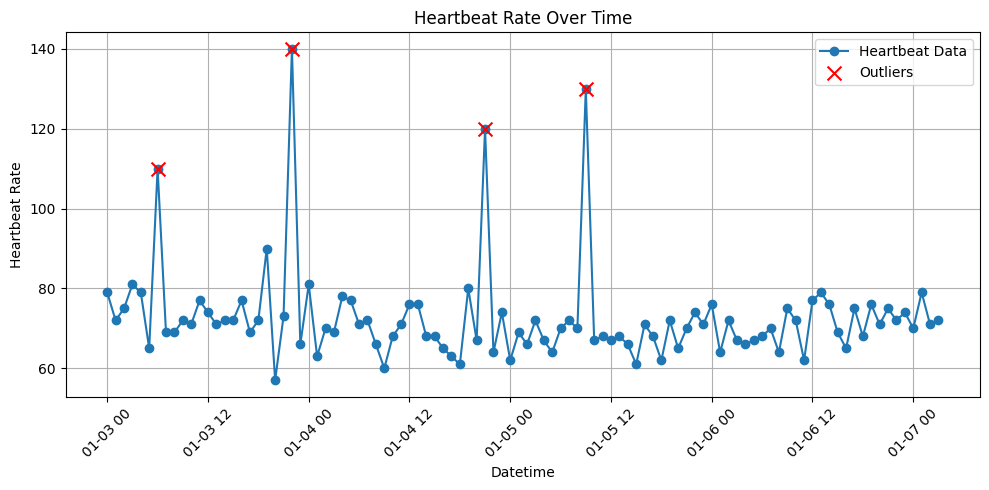

In [12]:
# 그래프의 크기를 10x5로 설정
plt.figure(figsize=(10, 5))

# 'datetime'을 x축으로, 'heartbeat_rate'를 y축으로 선 그래프 그리기
# marker='o'는 데이터 포인트를 원형 마커로 표시하고, linestyle='-'는 실선으로 연결
plt.plot(hb_data['datetime'], hb_data['heartbeat_rate'], marker='o', linestyle='-', label='Heartbeat Data')

# 이상치 데이터 포인트를 빨간색 X 마커로 표시
# outlier_indices는 이상치가 있는 데이터의 인덱스를 나타내므로 그에 해당하는 날짜와 심박수 값만 선택하여 표시
plt.scatter(hb_data['datetime'][outlier_indices], hb_data['heartbeat_rate'][outlier_indices],
            color='red', marker='x', s=100, label='Outliers', zorder=5)

# 그래프 제목 설정
plt.title('Heartbeat Rate Over Time')

# x축과 y축 레이블 설정
plt.xlabel('Datetime')
plt.ylabel('Heartbeat Rate')

# 그리드(격자선) 추가
plt.grid(True)

# x축 레이블의 날짜가 잘 보이도록 45도 회전
plt.xticks(rotation=45)

# 범례 표시 (선 그래프와 이상치 마커에 대한 설명)
plt.legend()

# 그래프 레이아웃을 자동으로 조정하여 요소들이 겹치지 않게 설정
plt.tight_layout()

# 그래프 출력
plt.show()

outlier_indices는 hb_data 데이터프레임의 열이 아니라, 데이터프레임의 행에 해당하는 불리언 인덱스이다.

불리언 인덱싱: True인 위치에 해당하는 값들을 선택하는 방식.


outlier_indices가 True인 인덱스를 기준으로 hb_data['heartbeat_rate']에서 이상치만 선택하는 작업을 한다는 의미이다.

장점:

	•	통계적 기초: Chauvenet의 기준은 통계적 추정에 기반하여 각 데이터 포인트의 Z-점수를 계산하고 이를 이론적 확률 분포와 비교함. 이 접근법은 수학적으로 엄밀하고 정당화됨.
	•	자동화: 추가적인 파라미터 설정 없이 데이터셋의 모든 값에 대해 이상치를 자동으로 판단하며, 데이터 자체에서 이상치를 식별할 수 있음.

단점:

	•	민감도: 극단적인 값이 많은 데이터셋에서는 너무 많은 데이터 포인트가 이상치로 분류될 수 있음.
	•	확률 임계값 의존성: 낮은 확률 임계값이 데이터셋의 크기에 따라 달라지므로, 작은 데이터셋에서는 더 많은 데이터가 이상치로 분류될 수 있음.

#### 1.2. Winsorizing
Winsorizing is a method to limit extreme values by replacing them with less extreme values.

In [ ]:
from scipy.stats.mstats import winsorize

In [ ]:
# Extract heartbeat rates
heartbeat_rates = hb_data['heartbeat_rate'].values

# Apply Winsorizing to the heartbeat data
winsorized_data = winsorize(heartbeat_rates, limits=[0.05, 0.05])

# Add winsorized data as a column in the dataset
hb_data['winsorized_rate'] = winsorized_data

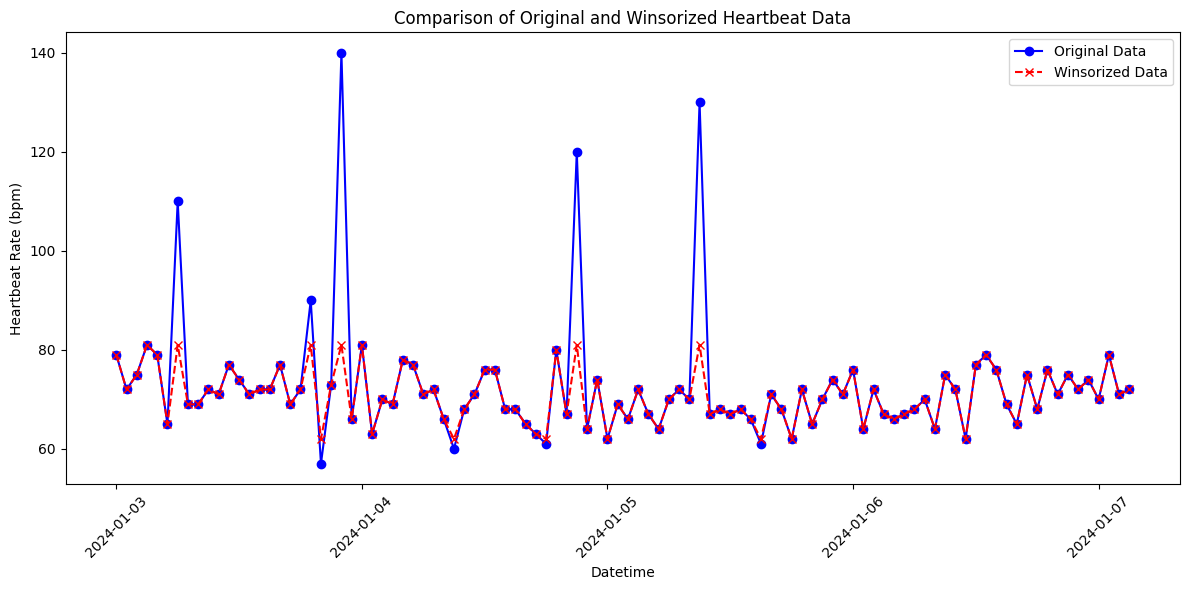

In [ ]:
plt.figure(figsize=(12, 6))

plt.plot(hb_data['datetime'], hb_data['heartbeat_rate'], label='Original Data', color='b', linestyle='-', marker='o')
plt.plot(hb_data['datetime'], hb_data['winsorized_rate'], label='Winsorized Data', color='r', linestyle='--', marker='x')

plt.title('Comparison of Original and Winsorized Heartbeat Data')
plt.xlabel('Datetime')
plt.ylabel('Heartbeat Rate (bpm)')

plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.DayLocator(interval=1))

plt.xticks(rotation=45)
plt.legend()

plt.tight_layout()
plt.show()

Advantages:
- Robustness: Winsorizing preserves the overall distribution of the data **by replacing extreme parts of the data rather than removing them**. This minimizes distortion in statistical analysis.
- Parameter Settings: Users can decide how much of the extremes to replace through Winsorizing, **offering flexibility according to the analytical purpose**

Disadvantages:
- Arbitrariness: Deciding how to replace extreme values **can be subjective**, and different analysts might choose different limit values.
- Data Modification: Modifying the original data can lead **to some loss of information about extreme values, potentially distorting the true characteristics of the data**.

### 2. Distance-Based Methods

#### 2.1. K-Nearest Neighbors (KNN) Outlier Detection
The K-Nearest Neighbors method identifies outliers by calculating the average distance from each data point to its k-nearest neighbors. Data points that have a significantly higher distance compared to the rest of the data set are considered outliers.

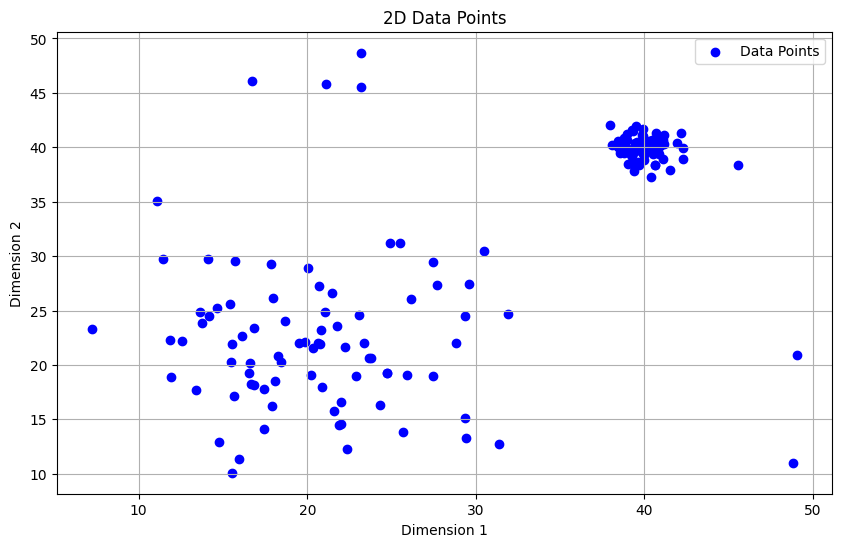

In [ ]:
from sklearn.datasets import make_blobs

# Random Seed
np.random.seed(0)

centers = [(20, 20), (40, 40)]
cluster_std = [5, 1]
X, _ = make_blobs(n_samples=150, centers=centers, cluster_std=cluster_std)

outliers = np.random.uniform(low=10, high=50, size=(10, 2))
data = np.vstack([X, outliers])

plt.figure(figsize=(10, 6))
plt.scatter(data[:, 0], data[:, 1], color='blue', label='Data Points')

plt.title('2D Data Points')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from sklearn.neighbors import NearestNeighbors

def detect_outliers_with_knn(data, n_neighbors=5, outlier_fraction=0.2):
    nbrs = NearestNeighbors(n_neighbors=n_neighbors + 1).fit(data)
    distances, indices = nbrs.kneighbors(data)
    mean_distance = distances[:, 1:].mean(axis=1)
    threshold = np.percentile(mean_distance, 100 * (1 - outlier_fraction))
    is_outlier = mean_distance > threshold
    outliers = data[is_outlier]
    return outliers, is_outlier, mean_distance, threshold

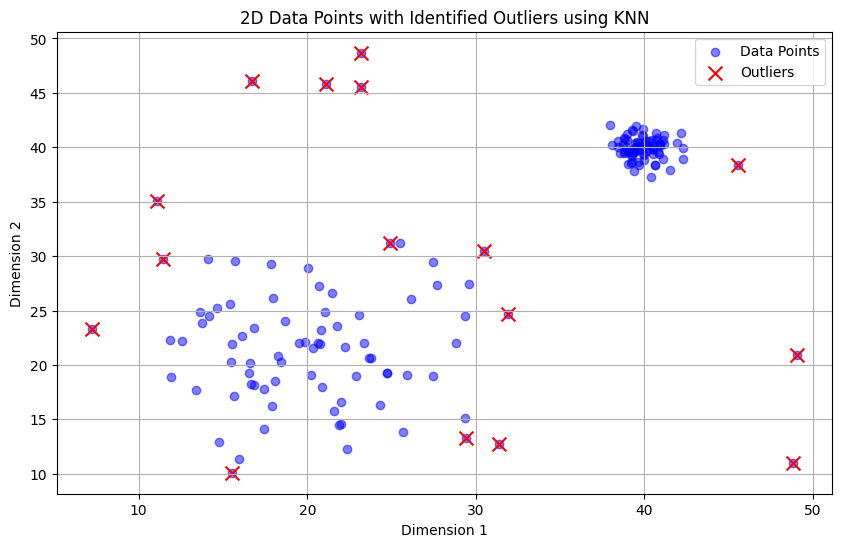

In [ ]:
# Outlier Detection
outliers_detected, is_outlier_mask, mean_distances, distance_threshold = detect_outliers_with_knn(data, n_neighbors=5, outlier_fraction=0.1)

# Data and Outlier Visualization
plt.figure(figsize=(10, 6))
plt.scatter(data[:, 0], data[:, 1], color='blue', label='Data Points', alpha=0.5)
plt.scatter(outliers_detected[:, 0], outliers_detected[:, 1], color='red', marker='x', s=100, label='Outliers')
plt.title('2D Data Points with Identified Outliers using KNN')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.grid(True)
plt.show()

Advantages

- Simple and Intuitive: The average distance is easy to understand and compute

- Adjustable: The strictness of outlier detection can be controlled by adjusting the n_neighbors and outlier_fraction parameters.

Disadvantages

- Assumption of Uniform Density: Assumes that all clusters or data regions have roughly the same density. **This can lead to incorrect outlier identification in data with clusters of varying densities**.

- Importance of Neighbor Count: Choosing the appropriate number of neighbors is crucial, and this choice can often be subjective or empirical.

#### 2.2. Local Outlier Factor (LOF)

LOF calculates the local density of each data point by comparing it to its neighbors and evaluates how anomalous the data point is based on this local density. If a data point has a substantially lower density than its neighbors, it is considered an outlier.

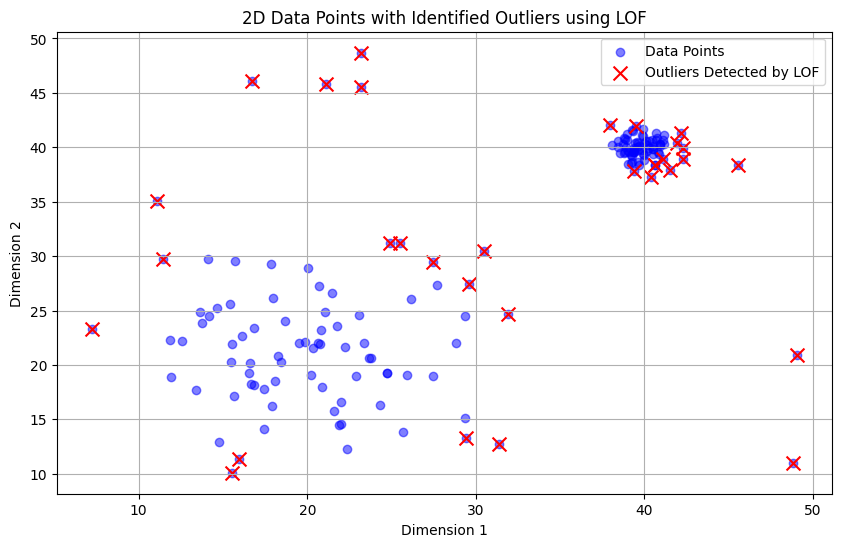

In [ ]:
from sklearn.neighbors import LocalOutlierFactor

# n_neighbors : The number of neighboring data points to consider when evaluating the local density of each data point
# Small Dataset (< 1000 points): Set between 5 and 20
# Medium Dataset (1000 ~ 10000 points): Set between 20 and 50
# Large Dataset (> 10000 points): Set to 50 or more, or adjust based on data density


# LOF 모델 초기화 및 학습
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.2)
is_outlier = lof.fit_predict(data) == -1
outliers_detected = data[is_outlier]

# 데이터와 이상치 시각화
plt.figure(figsize=(10, 6))
plt.scatter(data[:, 0], data[:, 1], color='blue', label='Data Points', alpha=0.5)
plt.scatter(outliers_detected[:, 0], outliers_detected[:, 1], color='red', marker='x', s=100, label='Outliers Detected by LOF')
plt.title('2D Data Points with Identified Outliers using LOF')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.grid(True)
plt.show()

Advantages

- **Density-Based Approach**: Works well with data of varying densities and is useful in non-uniform data distributions.

- More Sophisticated Analysis: By comparing the density of neighbors, it allows for a finer distinction of outliers than methods based solely on distance.

Disadvantages

- Computational Cost: Density calculation generally requires more computation than KNN, which can be time-consuming with large datasets.

- Parameter Dependence: The settings of parameters like n_neighbors and contamination significantly affect the results, requiring careful tuning.

Comparison: KNN v.s. LOF

- Application Areas: KNN is effective when the data has relatively uniform density as it considers only the distances between data points. On the other hand, LOF is more effective in data with diverse densities and can perform well in complex and non-uniform data structures.

- Computational Efficiency: KNN is faster and simpler in terms of computation, whereas LOF requires more computation and may take longer to process.

- **Precision in Outlier Detection: LOF, by considering the density of neighbors for detecting outliers, allows for more precise identification of outliers, although it requires proper parameter settings.**



#### LOF score for Data points

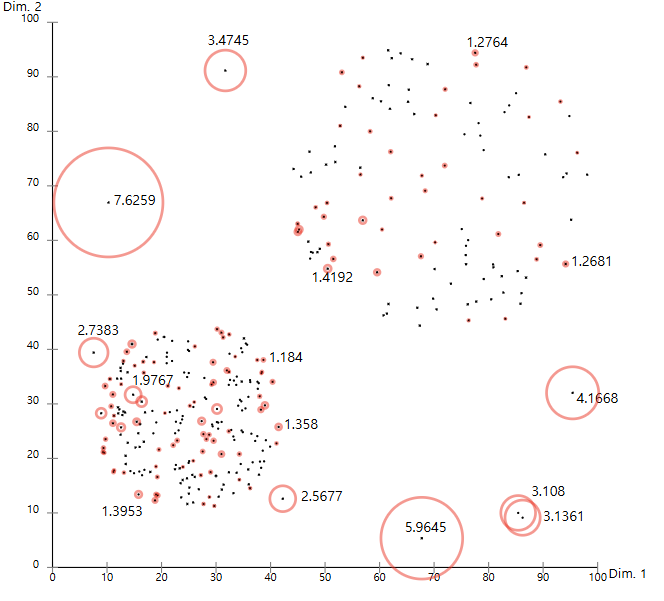

### 3. Domain Specific Methods

The EMA (Ecological Momentary Assessment) was conducted three times a day, every three days, and the answers from 1 to 5 represent the severity of the experienced symptom.

\<PHQ9_Questions\>

1. Feeling down, depressed, or hopeless (Depressed Mood)
2. Diminished interest or pleasure in usual activities. (diminished interest)
3. Difficulty falling asleep, frequent awakenings, or oversleeping. (insomnia or hypersomnia)
4. Decrease or increase in appetite compared to usual. (decrease/increase in appetite)
5. Noticeable slowness in speech and actions, or restlessness that others can observe. (psychomotor agitation or retardation)
6. Feeling tired and lacking energy. (fatigue or loss of energy)

7. Feeling guilty, like a failure, or thinking you’ve disappointed yourself or others. (feeling of worthlessness and/or guilt)

8. Difficulty concentrating on routine tasks (e.g., reading the newspaper, watching TV). (diminished ability to concentrate)

9. Thoughts that it might be better to be dead or recurrent thoughts of self-harm or suicide. (recurrent thoughts of self-injury or suicidal ideation)

10. Feeling down, sad, or hopeless (Consistency check question, same content as question number 1 [depressed mood] but rephrased)

In [ ]:
phq_ema = pd.read_csv('/content/drive/Shared drives/timeseries-datasets/aos_phq9_ema.csv')
phq_ema.head()

,pid,timestamp,ema_order,depressed_feeling,lack_of_interest,sleep_trouble,poor_appetite,bad_physchomotor_activity,fatigue,negative_self_image,difficulty_focusing,suicide_thoughts,consistency_check,duration,phq9_score
0,28,2021-08-17 12:00:33.170000+09:00,1,1,1,1,1,1,1,1,1,1,1,19954,9
1,28,2021-08-17 16:00:25.788000+09:00,2,1,1,1,1,1,2,1,1,1,1,19776,10
2,28,2021-08-17 20:00:22.256000+09:00,3,1,1,1,1,1,3,1,1,1,1,17504,11
3,28,2021-08-20 10:00:23.022000+09:00,1,1,1,3,1,1,2,1,1,1,1,18783,12
4,28,2021-08-20 14:00:33.223000+09:00,2,1,1,1,1,1,1,1,1,1,1,14428984,9


In [ ]:
phq_ema.tail()

,pid,timestamp,ema_order,depressed_feeling,lack_of_interest,sleep_trouble,poor_appetite,bad_physchomotor_activity,fatigue,negative_self_image,difficulty_focusing,suicide_thoughts,consistency_check,duration,phq9_score
3821,844,2022-02-09 12:27:46.897000+09:00,1,1,1,1,1,1,1,1,1,1,1,29095,9
3822,844,2022-02-09 20:00:23.022000+09:00,3,1,1,1,1,1,1,1,1,1,1,27185220,9
3823,844,2022-02-12 12:55:19.175000+09:00,1,1,1,1,1,1,1,1,1,1,1,34666,9
3824,844,2022-02-12 16:11:26.844000+09:00,2,1,1,1,1,1,1,1,1,1,1,11802335,9
3825,844,2022-02-12 20:03:00.189000+09:00,3,1,1,1,1,1,1,1,1,1,1,56719,9


We utilize two filters to enhance the reliability of the collected survey data.

1. Excluding EMAs where the reliability check question is answered incorrectly.


2. Removing EMAs that were answered too quickly or slowly.

In [ ]:
consistency_phq_ema = phq_ema[phq_ema['depressed_feeling'] == phq_ema['consistency_check']]

print("Before excluding : " + str(len(phq_ema)))
print("After excluding : " + str(len(consistency_phq_ema)))

consistency_phq_ema['duration'] = consistency_phq_ema['duration']/1000

Before excluding : 3826
After excluding : 3288


<ipython-input-82-586c5429fd81>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  consistency_phq_ema['duration'] = consistency_phq_ema['duration']/1000


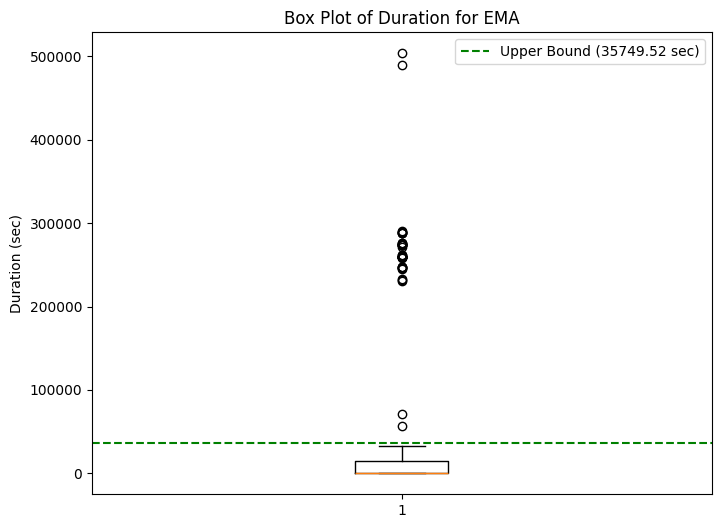

In [ ]:
# Calculate Q1 and Q3
Q1 = consistency_phq_ema['duration'].quantile(0.25)
Q3 = consistency_phq_ema['duration'].quantile(0.75)
IQR = Q3 - Q1  # Interquartile Range

# Define the bounds for outliers
#lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR


# Plotting the box plot with non-outlier range
plt.figure(figsize=(8, 6))
plt.boxplot(consistency_phq_ema['duration'], showfliers=True)  # Show outliers
# Adding lines for non-outlier range
# plt.axhline(y=lower_bound, color='red', linestyle='--', label=f'Lower Bound ({lower_bound:.2f})')
plt.axhline(y=upper_bound, color='green', linestyle='--', label=f'Upper Bound ({upper_bound:.2f} sec)')

# Adding titles and labels
plt.title('Box Plot of Duration for EMA')
plt.ylabel('Duration (sec)')
plt.legend()
plt.show()

In related works, many studies have removed EMA entries with a duration of less than 10%.

[1]\(15'Ubicomp)Trajectories of Depression: Unobtrusive Monitoring of Depressive States by means of Smartphone Mobility Traces Analysis

[2]\(23'Sensors)Improving Depression Severity Prediction from Passive
Sensing: Symptom-Profiling Approach

Additionally, since participants were given only one hour to respond to each EMA, entries with a duration exceeding one hour were removed.

Before excluding : 3288
After excluding : 1827


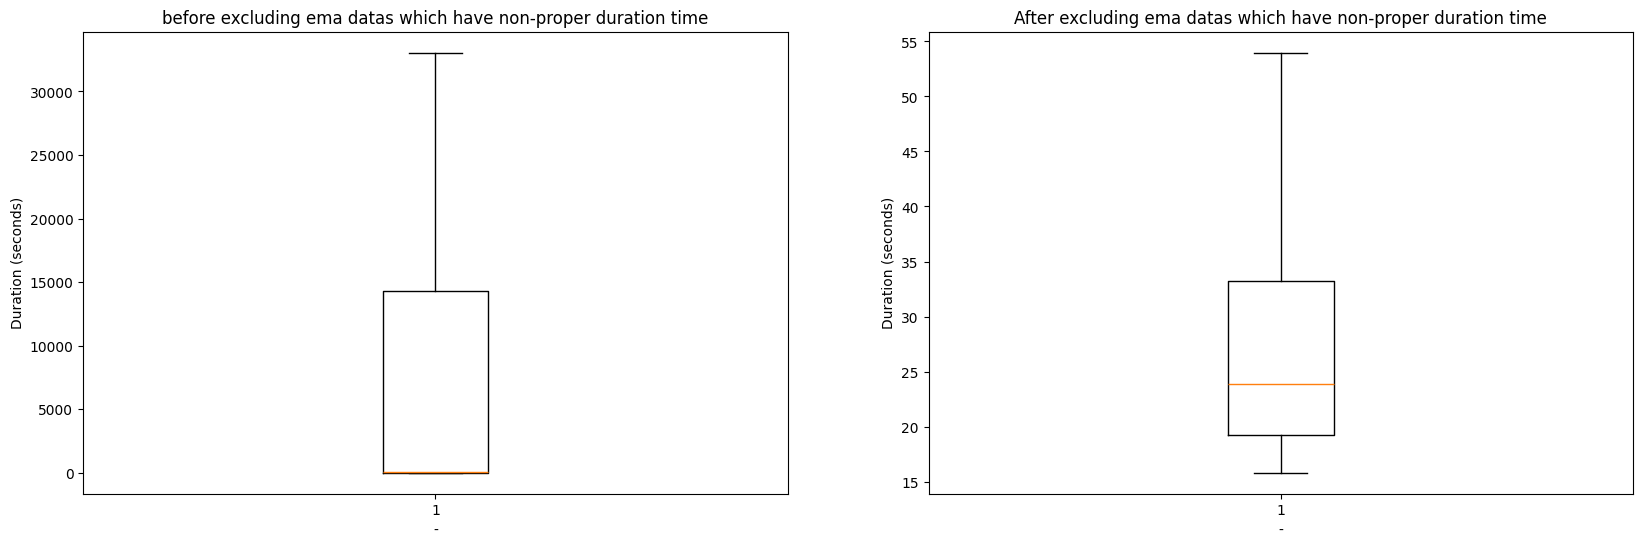

In [ ]:
duration_low_ten_percentile = consistency_phq_ema['duration'].quantile(0.10)

proper_duration_consistency_phq_ema = consistency_phq_ema[
    (consistency_phq_ema['duration'] >= duration_low_ten_percentile) &
   (consistency_phq_ema['duration'] <= 3600)
]

print("Before excluding : " + str(len(consistency_phq_ema)))
print("After excluding : " + str(len(proper_duration_consistency_phq_ema)))



plt.figure(figsize=(20, 6))

plt.subplot(1, 2, 1)
plt.boxplot(consistency_phq_ema['duration'].dropna(), showfliers=False)
plt.title('before excluding ema datas which have non-proper duration time')
plt.xlabel('-')
plt.ylabel('Duration (seconds)')

plt.subplot(1, 2, 2)
plt.boxplot(proper_duration_consistency_phq_ema['duration'].dropna(), showfliers=False)
plt.title('After excluding ema datas which have non-proper duration time')
plt.xlabel('-')
plt.ylabel('Duration (seconds)')

plt.show()

## Imputation of missing values
Missing values can be handled using various imputation techniques:

### 4. Imputation Methods


In [ ]:
step_data = pd.read_csv("/content/drive/Shared drives/timeseries-datasets/step_count_data.csv")
step_data.head()

,datetime,step_count
0,2024-01-23 00:00:00,0.0
1,2024-01-23 01:00:00,0.0
2,2024-01-23 02:00:00,NaN
3,2024-01-23 03:00:00,0.0
4,2024-01-23 04:00:00,0.0


In [ ]:
step_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99 entries, 0 to 98
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    99 non-null     object 
 1   step_count  89 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.7+ KB


In [ ]:
missing_values = step_data.isnull().sum()
missing_values

,0
datetime,0
step_count,10


#### 4.1. Mean Imputation
Replace missing values with the mean of the dataset.

In [ ]:
step_count_data = step_data['step_count'].values

In [ ]:
def mean_imputation(data):
    # Calculate the mean excluding NaN values
    mean_value = round(np.nanmean(data),0)
    # Replace NaN values with the mean
    mean_imputed_data = np.where(np.isnan(data), mean_value, data)
    return mean_imputed_data

In [ ]:
mean_imputed_data = mean_imputation(step_count_data)
step_data['mean_imputed'] = mean_imputed_data
step_data.head()

,datetime,step_count,mean_imputed
0,2024-01-23 00:00:00,0.0,0.0
1,2024-01-23 01:00:00,0.0,0.0
2,2024-01-23 02:00:00,NaN,11.0
3,2024-01-23 03:00:00,0.0,0.0
4,2024-01-23 04:00:00,0.0,0.0


#### 4.2. Median Imputation
Replace missing values with the median of the dataset.

In [ ]:
def median_imputation(data):
    median_value = np.median(data[~np.isnan(data)])
    median_imputed_data = np.where(np.isnan(data), median_value, data)
    return median_imputed_data

In [ ]:
median_imputed_data = median_imputation(step_count_data)
step_data['median_imputed'] = median_imputed_data
step_data.head()

,datetime,step_count,mean_imputed,median_imputed
0,2024-01-23 00:00:00,0.0,0.0,0.0
1,2024-01-23 01:00:00,0.0,0.0,0.0
2,2024-01-23 02:00:00,NaN,11.0,3.0
3,2024-01-23 03:00:00,0.0,0.0,0.0
4,2024-01-23 04:00:00,0.0,0.0,0.0


#### 4.3. Mode Imputation
Replace missing values with the mode of the dataset.
"mode of the dataset" refers to the most frequently occurring value in the dataset

In [ ]:
def mode_imputation(data):
    data_no_nan = data[~np.isnan(data)]
    # Numpy has no direct method to calculate the mode
    values, counts = np.unique(data_no_nan, return_counts=True)
    mode_value = values[np.argmax(counts)]

    mode_imputed_data = np.where(np.isnan(data), mode_value, data)
    return mode_imputed_data

In [ ]:
mode_imputed_data = mode_imputation(step_count_data)
step_data['mode_imputed'] = mode_imputed_data
step_data.head()

,datetime,step_count,mean_imputed,median_imputed,mode_imputed
0,2024-01-23 00:00:00,0.0,0.0,0.0,0.0
1,2024-01-23 01:00:00,0.0,0.0,0.0,0.0
2,2024-01-23 02:00:00,NaN,11.0,3.0,0.0
3,2024-01-23 03:00:00,0.0,0.0,0.0,0.0
4,2024-01-23 04:00:00,0.0,0.0,0.0,0.0


In [ ]:
nan_rows = step_data[step_data['step_count'].isnull()]
nan_rows

,datetime,step_count,mean_imputed,median_imputed,mode_imputed
2,2024-01-23 02:00:00,NaN,11.0,3.0,0.0
25,2024-01-24 01:00:00,NaN,11.0,3.0,0.0
26,2024-01-24 02:00:00,NaN,11.0,3.0,0.0
35,2024-01-24 11:00:00,NaN,11.0,3.0,0.0
36,2024-01-24 12:00:00,NaN,11.0,3.0,0.0
49,2024-01-25 01:00:00,NaN,11.0,3.0,0.0
51,2024-01-25 03:00:00,NaN,11.0,3.0,0.0
61,2024-01-25 13:00:00,NaN,11.0,3.0,0.0
80,2024-01-26 08:00:00,NaN,11.0,3.0,0.0
97,2024-01-27 01:00:00,NaN,11.0,3.0,0.0


### 5. Low Pass Filter
Low Pass Filters are used to smooth the data and remove high-frequency noise. Often used to remove noise, as noise is mainly present at high frequencies

- Data Filtering: First, the low_pass_filter function is used to remove high-frequency noise from the data. In this process, essential low-frequency components of the data are preserved, while unwanted short fluctuations or noise are filtered out. Filtering smooths the data, enhancing the quality of the signal for analysis or other processing steps.

- Data Imputation: The filtered data can be used to estimate missing values or impute gaps. For example, in time series data, missing parts can be filled in by analyzing the pattern of surrounding data. Because the filtered data is smoother, the imputed values are likely to be more consistent and accurate.

In [ ]:
from scipy.signal import butter, filtfilt

def low_pass_filter(data, cutoff=0.1, fs=1.0, order=5):
    """

    Apply a low-pass Butterworth filter to the input data.

    Parameters:
    data (array-like): Input signal data (1-D array).
    cutoff (float): Cutoff frequency of the filter (in the same units as fs, e.g., Hz).
    fs (float): Sampling rate of the input signal.
    order (int): Order of the filter, higher order means a sharper cutoff.

    Returns:
    array-like: Filtered signal.
    """
    # Validate input parameters
    if cutoff >= fs / 2:
        raise ValueError("Cutoff frequency must be less than half the sampling rate.")
    if order < 1:
        raise ValueError("Order must be at least 1.")

    # Calculate Nyquist frequency
    nyquist = 0.5 * fs

    # Normalize the frequency
    normal_cutoff = cutoff / nyquist

    # Generate Butterworth filter coefficients
    b, a = butter(order, normal_cutoff, btype='low', analog=False)

    # Apply the filter using filtfilt for zero phase distortion
    filtered_data = filtfilt(b, a, data)

    return filtered_data

In [ ]:
filtered_data = low_pass_filter(heartbeat_rates)
rounded_filtered_data = np.round(filtered_data, 0)
hb_data['hb_lowpass_filter'] = rounded_filtered_data

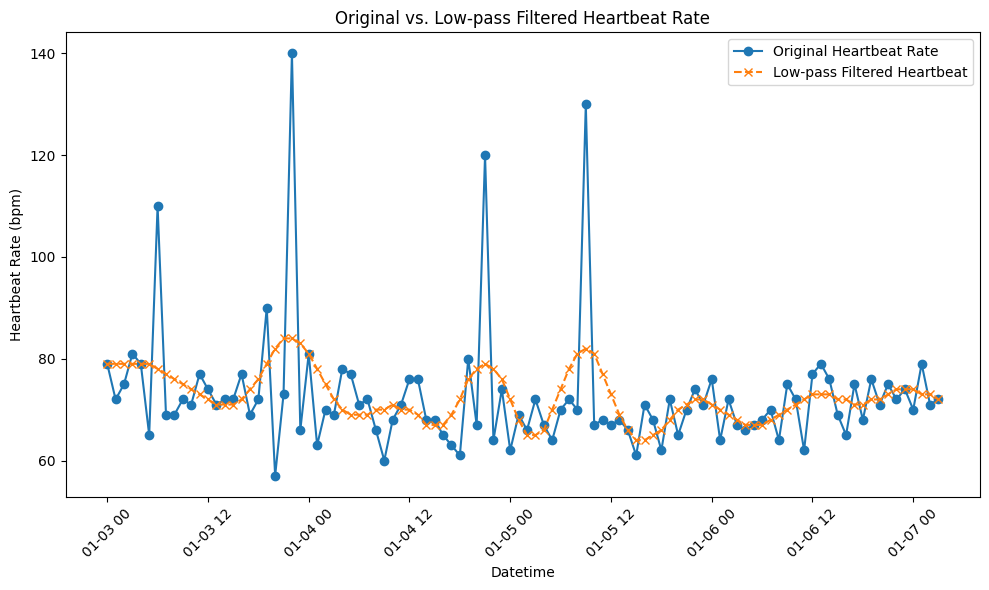

In [ ]:
plt.figure(figsize=(10, 6))

plt.plot(hb_data['datetime'], hb_data['heartbeat_rate'], label='Original Heartbeat Rate', linestyle='-', marker='o')
plt.plot(hb_data['datetime'], hb_data['hb_lowpass_filter'], label='Low-pass Filtered Heartbeat', linestyle='--', marker='x')

plt.title('Original vs. Low-pass Filtered Heartbeat Rate')
plt.xlabel('Datetime')
plt.ylabel('Heartbeat Rate (bpm)')
plt.legend()
plt.xticks(rotation=45)


plt.tight_layout()
plt.show()

Advantages:

- Noise Reduction : Low-pass filters effectively remove high-frequency noise, allowing only the useful low-frequency components of the signal to remain.

Disadvantages:

- Increased Computational Cost: As the filter order increases, so does the computation required, which can impact performance when processing large data volumes or in real-time applications.

- **Data Loss: Setting the cutoff frequency too low can remove important high-frequency components as well.**